In [ ]:
# Source: https://www.kaggle.com/code/scratchpad/notebookade3e4a918/edit

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cpu


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [8]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [9]:
class CVAE(nn.Module):
    
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=20):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

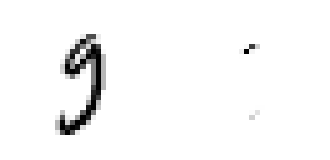

epoch:   5%|▌         | 1/20 [00:10<03:21, 10.61s/it]


Epoch 001 val_loss 0.9166


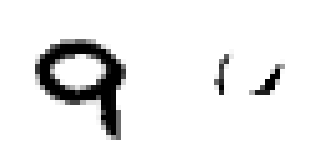

epoch:  10%|█         | 2/20 [00:28<04:25, 14.76s/it]


Epoch 002 val_loss 0.8979


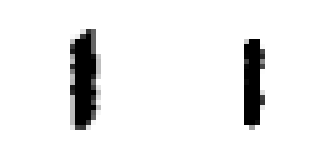

epoch:  15%|█▌        | 3/20 [00:36<03:19, 11.75s/it]


Epoch 003 val_loss 0.8835


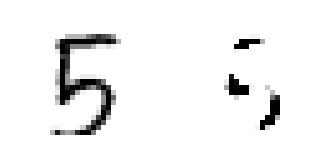

epoch:  20%|██        | 4/20 [00:44<02:46, 10.41s/it]


Epoch 004 val_loss 0.8757


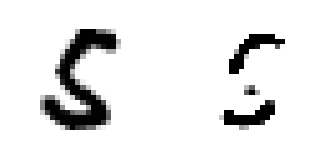

epoch:  25%|██▌       | 5/20 [00:53<02:24,  9.63s/it]


Epoch 005 val_loss 0.8717


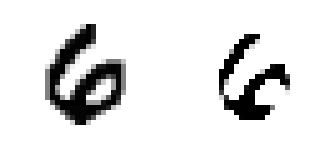

epoch:  30%|███       | 6/20 [01:01<02:07,  9.08s/it]


Epoch 006 val_loss 0.8678


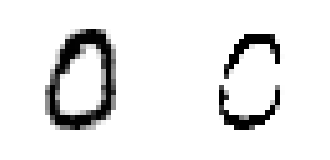

epoch:  35%|███▌      | 7/20 [01:09<01:57,  9.03s/it]


Epoch 007 val_loss 0.8668


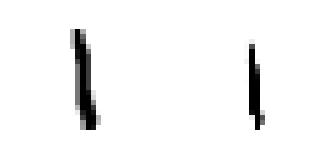

epoch:  40%|████      | 8/20 [01:18<01:48,  9.01s/it]


Epoch 008 val_loss 0.8630


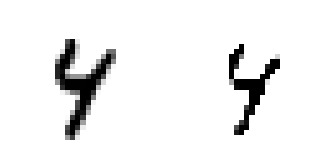

epoch:  45%|████▌     | 9/20 [01:28<01:40,  9.15s/it]


Epoch 009 val_loss 0.8606


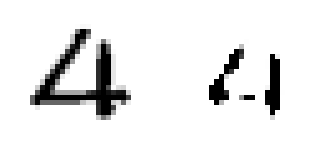

epoch:  50%|█████     | 10/20 [01:37<01:30,  9.03s/it]


Epoch 010 val_loss 0.8613


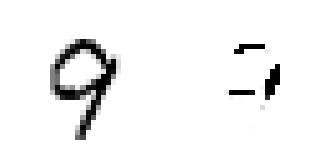

epoch:  55%|█████▌    | 11/20 [01:46<01:21,  9.05s/it]


Epoch 011 val_loss 0.8596


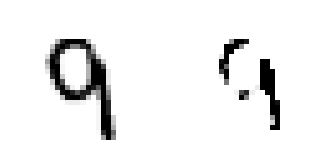

epoch:  60%|██████    | 12/20 [01:57<01:17,  9.70s/it]


Epoch 012 val_loss 0.8580


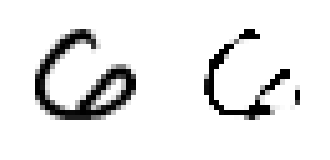

epoch:  65%|██████▌   | 13/20 [02:07<01:07,  9.71s/it]


Epoch 013 val_loss 0.8584


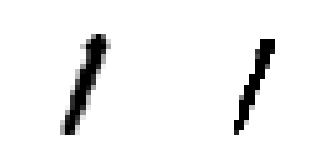

epoch:  70%|███████   | 14/20 [02:18<01:00, 10.09s/it]


Epoch 014 val_loss 0.8567


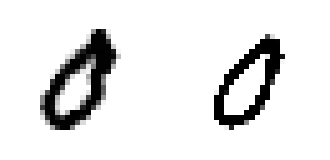

epoch:  75%|███████▌  | 15/20 [02:30<00:53, 10.77s/it]


Epoch 015 val_loss 0.8562


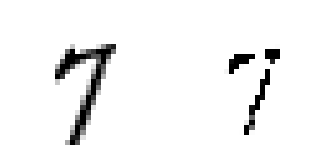

epoch:  80%|████████  | 16/20 [02:39<00:40, 10.24s/it]


Epoch 016 val_loss 0.8554


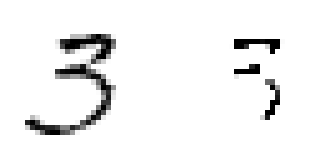

epoch:  85%|████████▌ | 17/20 [02:48<00:29,  9.91s/it]


Epoch 017 val_loss 0.8568


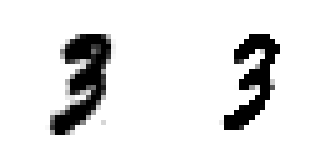

epoch:  90%|█████████ | 18/20 [02:56<00:18,  9.32s/it]


Epoch 018 val_loss 0.8545


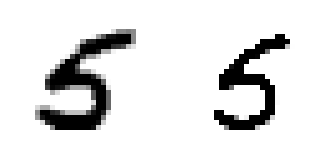

epoch:  95%|█████████▌| 19/20 [03:06<00:09,  9.58s/it]


Epoch 019 val_loss 0.8554


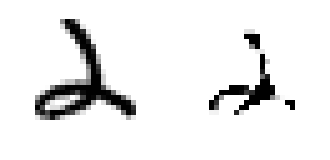

epoch: 100%|██████████| 20/20 [03:14<00:00,  9.73s/it]


Epoch 020 val_loss 0.8540


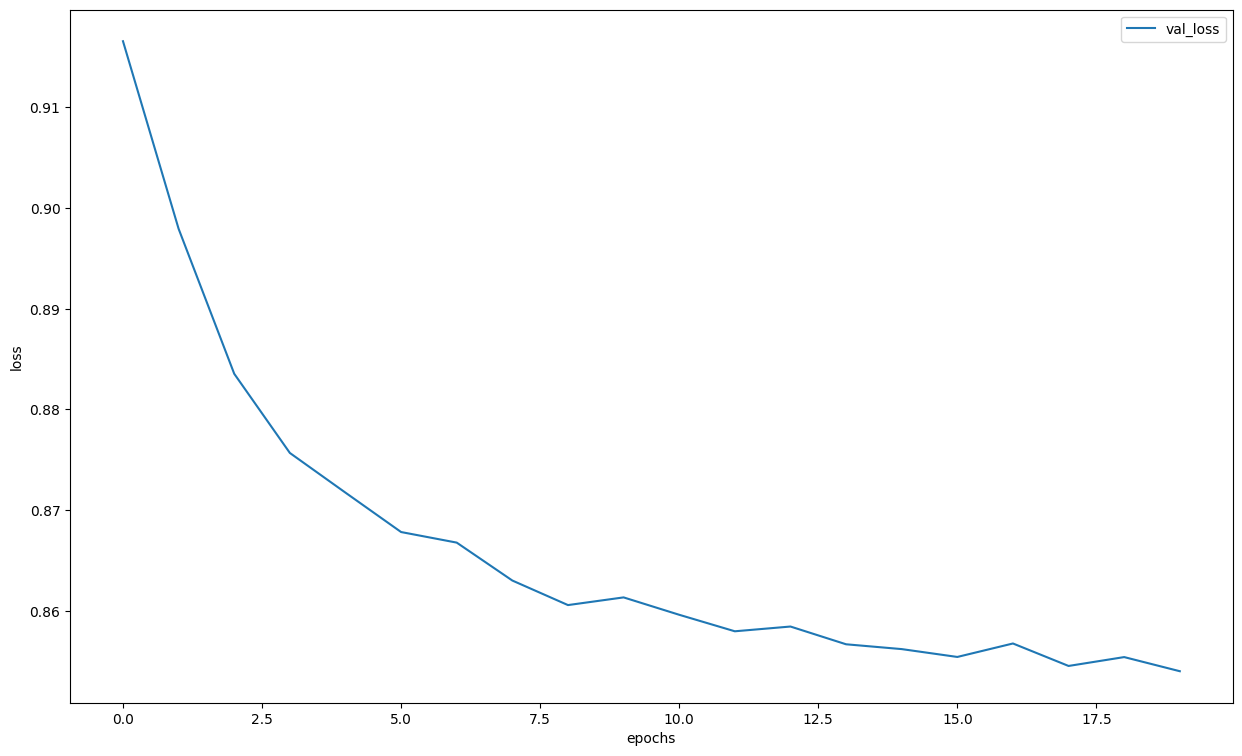

In [10]:
cvae = CVAE(28*28).to(DEVICE)
history = train_cvae(cvae, train_dataset, val_dataset)

val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels



def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

In [ ]:
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)